In [1]:
import numpy as np
import numpy.matlib
from matplotlib import pyplot as plt
import math
import time

In [2]:
def getEuclideanDistance(single_point,array):
    nrows, ncols, nfeatures=array.shape[0],array.shape[1], array.shape[2]
    points=array.reshape((nrows*ncols,nfeatures))
                         
    dist = (points - single_point)**2
    dist = np.sum(dist, axis=1)
    dist = np.sqrt(dist)

    dist=dist.reshape((nrows,ncols))
    return dist

In [4]:

mu, sigma = 0, 0.1
A = np.random.normal(mu, sigma, 10)
print(A.shape, A)

(10,) [ 0.09586764 -0.14801379 -0.1614256  -0.1509443  -0.08661788  0.01708137
  0.17602995  0.05589433  0.07194406 -0.09961369]


In [5]:
nrows,ncols,nfeatures=3,3,3

#Generate coordinate system
x,y=np.meshgrid(range(ncols),range(nrows))

In [7]:

sgm0=2
sgmdecay=0.05
t=1
sgm = sgm0 * math.exp(-t*sgmdecay)

width = math.ceil(sgm*3)

dist=np.array([[2,1,3],[3,2,3],[4,4,4]])
bmurow, bmucol =np.unravel_index(np.argmin(dist, axis=None), dist.shape) 

g = np.exp(-((np.power(x - bmucol,2)) + (np.power(y - bmurow,2))) / (2*sgm*sgm))


fromrow = max(0,bmurow - width)
torow   = min(bmurow + width,nrows)
fromcol = max(0,bmucol - width)
tocol   = min(bmucol + width,ncols)



In [8]:
G = np.dstack([g[fromrow:torow,fromcol:tocol]]*nfeatures)



In [10]:
def SOM (dispRes, trainingData, ndim=10, nepochs=10, eta0=0.1, etadecay=0.05, sgm0=20, sgmdecay=0.05, showMode=0):
    nfeatures=trainingData.shape[1]
    ntrainingvectors=trainingData.shape[0]
    
    nrows = ndim
    ncols = ndim
    
    mu, sigma = 0, 0.1
    numpy.random.seed(int(time.time()))
    som = np.random.normal(mu, sigma, (nrows,ncols,nfeatures))

    if showMode >= 1:
        print("\nSOM features before training: \n")
        
        fig, ax=plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,15))
        
        for k in range(nrows):
            for l in range (ncols):
                A=som[k,l,:].reshape((dispRes[0],dispRes[1]))
                ax[k,l].imshow(A,cmap="plasma")
                ax[k,l].set_yticks([])
                ax[k,l].set_xticks([])   
    
    #Generate coordinate system
    x,y=np.meshgrid(range(ncols),range(nrows))
    
    
    for t in range (1,nepochs+1):
        #Compute the learning rate for the current epoch
        eta = eta0 * math.exp(-t*etadecay)
        
        #Compute the variance of the Gaussian (Neighbourhood) function for the ucrrent epoch
        sgm = sgm0 * math.exp(-t*sgmdecay)
        
        #Consider the width of the Gaussian function as 3 sigma
        width = math.ceil(sgm*3)
        
        for ntraining in range(ntrainingvectors):
            trainingVector = trainingData[ntraining,:]
            
            # Compute the Euclidean distance between the training vector and
            # each neuron in the SOM map
            dist = getEuclideanDistance(trainingVector, som)
       
            # Find 2D coordinates of the Best Matching Unit (bmu)
            bmurow, bmucol =np.unravel_index(np.argmin(dist, axis=None), dist.shape)
            
            
            #Generate a Gaussian function centered on the location of the bmu
            g = np.exp(-((np.power(x - bmucol,2)) + (np.power(y - bmurow,2))) / (2*sgm*sgm))

            #Determine the boundary of the local neighbourhood
            fromrow = max(0,bmurow - width)
            torow   = min(bmurow + width,nrows)
            fromcol = max(0,bmucol - width)
            tocol   = min(bmucol + width,ncols)

            
            #Get the neighbouring neurons and determine the size of the neighbourhood
            neighbourNeurons = som[fromrow:torow,fromcol:tocol,:]
            sz = neighbourNeurons.shape
            
            #Transform the training vector and the Gaussian function into 
            # multi-dimensional to facilitate the computation of the neuron weights update
            T = np.matlib.repmat(trainingVector,sz[0]*sz[1],1).reshape((sz[0],sz[1],nfeatures));                   
            G = np.dstack([g[fromrow:torow,fromcol:tocol]]*nfeatures)

            # Update the weights of the neurons that are in the neighbourhood of the bmu
            neighbourNeurons = neighbourNeurons + eta * G * (T - neighbourNeurons)

            
            #Put the new weights of the BMU neighbouring neurons back to the
            #entire SOM map
            som[fromrow:torow,fromcol:tocol,:] = neighbourNeurons

    if showMode >= 1:
        print("\nSOM features AFTER training: \n")
        
        fig, ax=plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,15))
        
        for k in range(nrows):
            for l in range (ncols):
                A=som[k,l,:].reshape((dispRes[0],dispRes[1]))
                ax[k,l].imshow(A,cmap="plasma")
                ax[k,l].set_yticks([])
            ax[k,l].set_xticks([])   
    return som
    

Task 1.1

In [33]:
import pandas as pd
from pathlib import Path

def parse_language_folder(path):
    base_path = Path(path)

    text = []
    labels = []
    classes = []

    for lang in sorted(base_path.iterdir()): # Look through each language directory and file on the format: "path/language_name/sentence"
        if lang.is_dir():
            language = lang.name
            classes.append(language)

            for file in lang.iterdir():
                if file.is_file():
                    with open(file, 'r', encoding='utf-8') as f:
                        for line in f:
                            line = line.strip()
                            if line:
                                labels.append(language)
                                text = ' '.join(line.split())
                            else:
                                continue

    input_data = pd.DataFrame({'text': text, "labels": labels})

    input_database = {
        0: input_data[["text"]].to_numpy()
    }

    return input_database, labels, classes


In [ ]:
path = 'text_data/'
input_vector_database, labels, classes = parse_language_folder(path)

X = input_vector_database[0]
y = np.array(labels)

n_samples = len(X) # Extract samples and shuffle
indices = np.arange(n_samples)
np.random.shuffle(indices)

train_end = int(0.8 * n_samples) # Where we split
val_end = int(0.9 * n_samples)

train_index = indices[:train_end] # Make the 3 sets train val test
val_index = indices[train_end:val_end]
test_index = indices[val_end:]

X_train = X[train_index]
X_val = X[val_index]
X_test = X[test_index]

y_train = y[train_index]
y_val = y[val_index]
y_test = y[test_index]

print("Total samples:", n_samples)
print("Train size   :", len(X_train))
print("Val size     :", len(X_val))
print("Test size    :", len(X_test))


Total samples: 878167
Train size   : 702533
Val size     : 87817
Test size    : 87817



SOM features before training: 



ValueError: cannot reshape array of size 1 into shape (4,4)

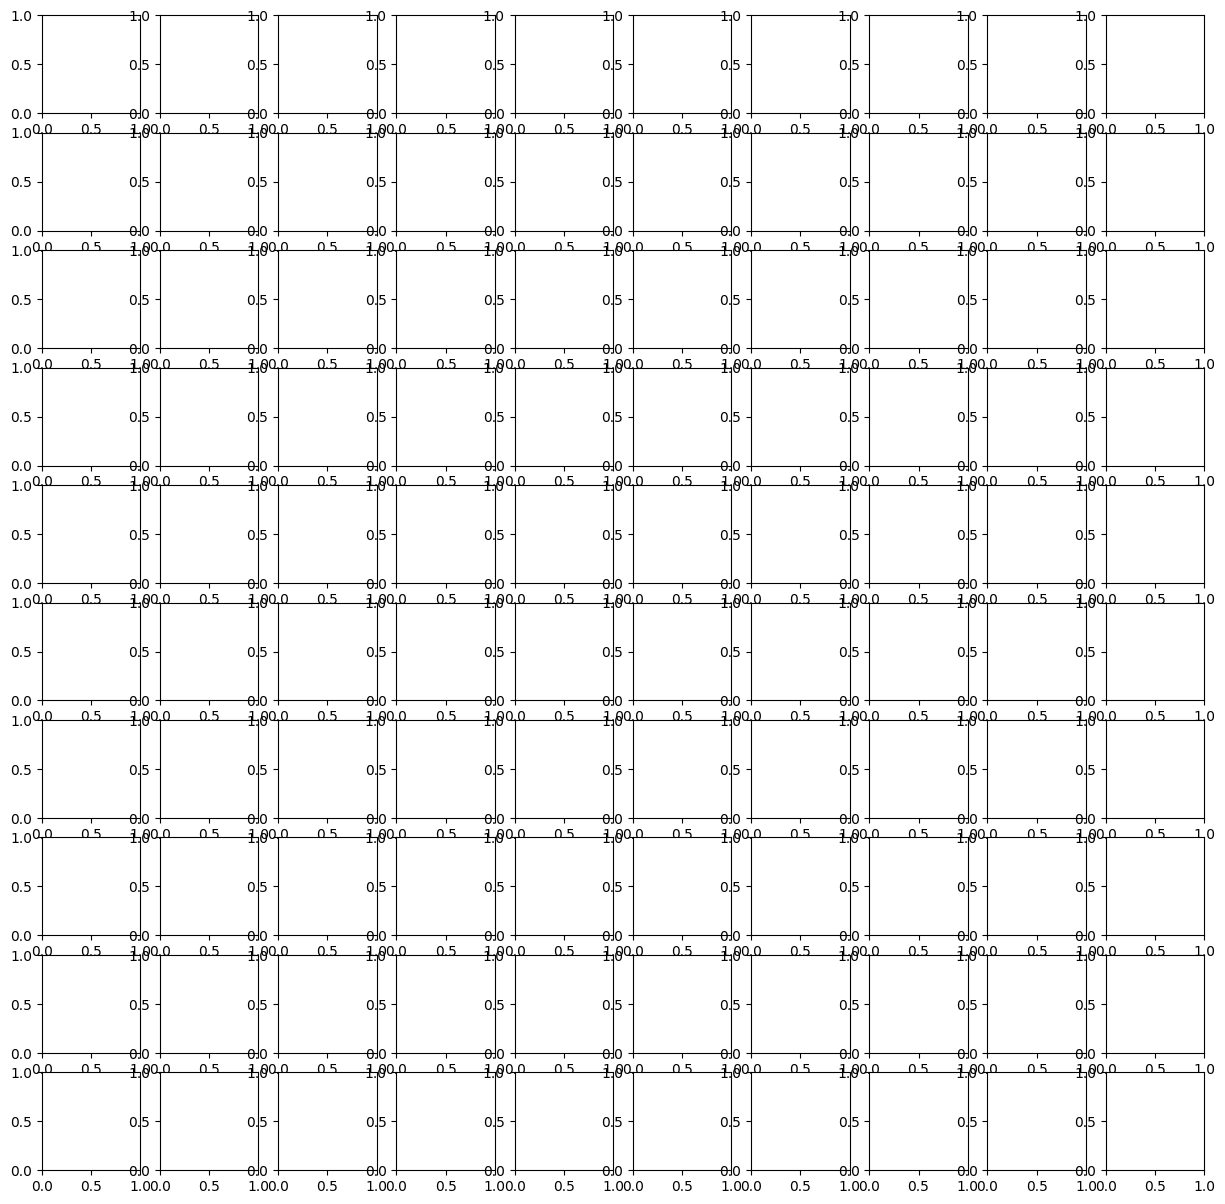

In [37]:
som_trained=SOM ([4,4],input_vector_database[0], ndim=10, nepochs=100, eta0=0.01, etadecay=0.05, sgm0=20, sgmdecay=0.05, showMode=1)


In [14]:
plt.show()


In [ ]:
#verification of correctness on the training set:



def SOM_Test (trainingData, som_, classes, grid_, ConfusionMatrix, ndim=60):
    nfeatures=trainingData.shape[1]
    ntrainingvectors=trainingData.shape[0]
    
    nrows = ndim
    ncols = ndim
    
    nclasses=np.max(classes)

    som_cl=np.zeros((ndim,ndim,nclasses+1))
    
    
    for ntraining in range(ntrainingvectors):
        trainingVector = trainingData[ntraining,:]
        class_of_sample= classes[ntraining]    
        # Compute the Euclidean distance between the training vector and
        # each neuron in the SOM map
        dist = getEuclideanDistance(trainingVector, som_)
       
        # Find 2D coordinates of the Best Matching Unit (bmu)
        bmurow, bmucol =np.unravel_index(np.argmin(dist, axis=None), dist.shape)
        
        
        som_cl[bmurow, bmucol,class_of_sample]=som_cl[bmurow, bmucol,class_of_sample]+1
    
    
    
    for i in range (nrows):
        for j in range (ncols):
            grid_[i,j]=np.argmax(som_cl[i,j,:])

 
    for ntraining in range(ntrainingvectors):
        trainingVector = trainingData[ntraining,:]
        class_of_sample= classes[ntraining]    
        # Compute the Euclidean distance between the training vector and
        # each neuron in the SOM map
        dist = getEuclideanDistance(trainingVector, som_)
       
        # Find 2D coordinates of the Best Matching Unit (bmu)
        bmurow, bmucol =np.unravel_index(np.argmin(dist, axis=None), dist.shape)
        
        predicted=np.argmax(som_cl[bmurow, bmucol,:])
        ConfusionMatrix[class_of_sample-1, predicted-1]=ConfusionMatrix[class_of_sample-1, predicted-1]+1
        
    return grid_, ConfusionMatrix
    



In [8]:
ndim=10
nrows=ndim
ncols=ndim
grid_color=np.zeros((nrows,ncols))
nclasses=np.max(classes)

Confusion_Matrix=np.zeros((nclasses,nclasses))
grid_color,Confusion_Matrix=SOM_Test (input_vector_database[0], som_trained, classes, grid_color, Confusion_Matrix, ndim)




In [13]:
plt.close()
plt.imshow(grid_color)
plt.show()

In [14]:
#Confusion_Matrix, input_vector_database[0].shape, np.sum(Confusion_Matrix)